<a href="https://colab.research.google.com/github/Nadia269/NLP_Sentiment_Analysis_Task/blob/main/sentiment_Analysis_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Dependencies

In [29]:
!pip install tensorflow nltk pandas scikit-learn

#Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Download and Load Dataset

In [2]:
from tensorflow.keras.datasets import imdb

print("Loading IMDB dataset from Keras...")
(X_train_raw, y_train), (X_test_raw, y_test) = imdb.load_data(num_words=10000)

word_index = imdb.get_word_index()

reverse_word_index = {value: key for key, value in word_index.items()}

def sequence_to_text(sequence):
    return ' '.join([reverse_word_index.get(i-3, '?') for i in sequence if i > 3])

print("Converting sequences to text...")
X_train_text = [sequence_to_text(sequence) for sequence in X_train_raw]
X_test_text = [sequence_to_text(sequence) for sequence in X_test_raw]

df = pd.DataFrame({
    'review': X_train_text[:5000] + X_test_text[:5000],
    'sentiment': np.concatenate([y_train[:5000], y_test[:5000]])
})

print("Dataset created. Shape:", df.shape)
print("Columns:", df.columns)
print("First 5 records:")
display(df.head())

print("\nClass distribution:")
print(df['sentiment'].value_counts())

Loading IMDB dataset from Keras...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Converting sequences to text...
Dataset created. Shape: (10000, 2)
Columns: Index(['review', 'sentiment'], dtype='object')
First 5 records:


,review,sentiment
0,this film was just brilliant casting location ...,1
1,big hair big boobs bad music and a giant safet...,0
2,this has to be one of the worst films of the 1...,0
3,the at storytelling the traditional sort many ...,1
4,worst mistake of my life br br i picked this m...,0



Class distribution:
sentiment
0    5025
1    4975
Name: count, dtype: int64


#Data Preprocessing

In [3]:
def clean_text(text):
    text = re.sub('<.*?>', ' ', text)

    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub('\s+', ' ', text).strip()

    words = text.lower().split()

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

print("\nCleaning text data...")
df['cleaned_review'] = df['review'].apply(clean_text)

df['review_length'] = df['cleaned_review'].apply(len)
print(f"Average review length: {df['review_length'].mean():.1f} characters")

X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_review'],
    df['sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)


Cleaning text data...
Average review length: 714.5 characters


#Prepare Data for LSTM

In [4]:
print("\nPreparing text for LSTM...")
max_words = 15000
max_len = 250

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

train_lens = [len(x) for x in X_train_seq]
print(f"Average sequence length: {np.mean(train_lens):.1f}")
print(f"Median sequence length: {np.median(train_lens):.1f}")
print(f"95th percentile length: {np.percentile(train_lens, 95):.1f}")

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Number of unique words used: {min(len(tokenizer.word_index), max_words)}")
print(f"Sequence shape: {X_train_pad.shape}")


Preparing text for LSTM...
Average sequence length: 108.7
Median sequence length: 81.0
95th percentile length: 280.0
Vocabulary size: 9496
Number of unique words used: 9496
Sequence shape: (8000, 250)


#Build and Compile LSTM Model

In [9]:
print("\nBuilding LSTM model with strong regularization...")
embedding_dim = 100

from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len,
              embeddings_regularizer=l2(1e-5)),

    Dropout(0.5),

    Bidirectional(LSTM(64, return_sequences=True,
                   dropout=0.4,
                   recurrent_dropout=0.4,
                   kernel_regularizer=l2(1e-5),
                   recurrent_regularizer=l2(1e-5))),

    GlobalMaxPooling1D(),

    BatchNormalization(),
    Dense(64, activation='relu',
          kernel_regularizer=l2(1e-4),
          bias_regularizer=l2(1e-4)),
    Dropout(0.5),

    Dense(1, activation='sigmoid',
          kernel_regularizer=l2(1e-4))
])

model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.build(input_shape=(None, max_len))

print(model.summary())


Building LSTM model with strong regularization...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 100)            │       1,500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 250, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 250, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,593,313 (6.08 MB)

 Trainable params: 1,593,057 (6.08 MB)

 Non-trainable params: 256 (1.00 KB)

None


#Train the Model

In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    min_delta=0.001
)

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

print("\nTraining LSTM model...")
history = model.fit(
    X_train_pad, y_train,
    epochs=8,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Training LSTM model...
Epoch 1/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 812ms/step - accuracy: 0.5087 - loss: 0.7555 - val_accuracy: 0.5138 - val_loss: 0.7137 - learning_rate: 3.0000e-04
Epoch 2/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 801ms/step - accuracy: 0.5609 - loss: 0.7099 - val_accuracy: 0.5138 - val_loss: 0.7092 - learning_rate: 3.0000e-04
Epoch 3/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 821ms/step - accuracy: 0.6387 - loss: 0.6623 - val_accuracy: 0.5688 - val_loss: 0.6787 - learning_rate: 3.0000e-04
Epoch 4/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 141s 811ms/step - accuracy: 0.7659 - loss: 0.5243 - val_accuracy: 0.8094 - val_loss: 0.5649 - learning_rate: 3.0000e-04
Epoch 5/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 820ms/step - accuracy: 0.8311 - loss: 0.4117 - val_accuracy: 0.8244 - val_loss: 0.4600 - learning_rate: 3.0000e-04
Epoch 6/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 826ms/step - accuracy: 0.8769 - loss: 0.3285 - val_accuracy: 0.8413 - val_loss: 0.3926 - learning_rate: 3.0000e-04
Epoch 7/8
100/100 ━━━━━━━━━

#Visualize Training Results

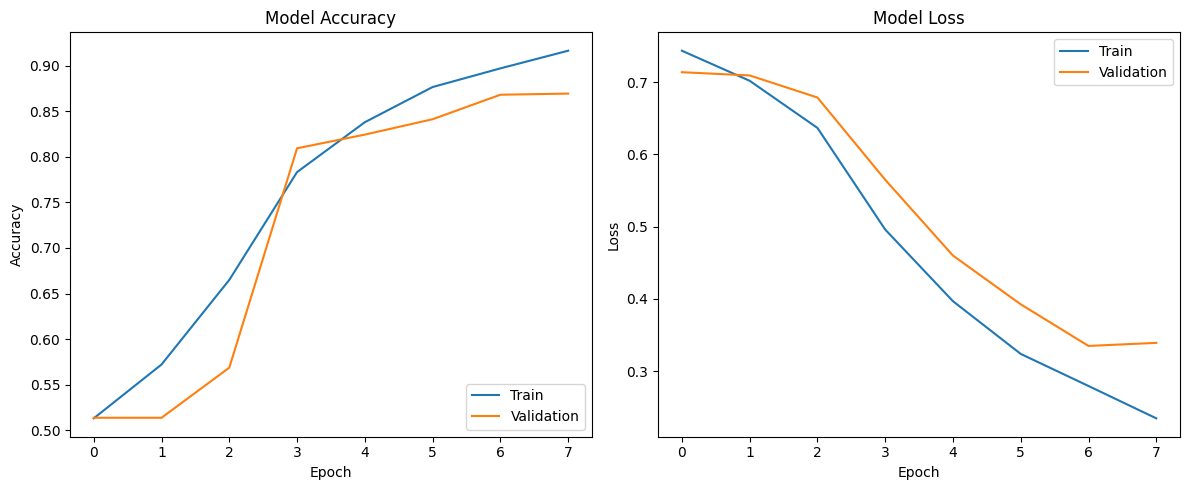


Evaluating model...
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.8688 - loss: 0.3351
Test Loss: 0.3415
Test Accuracy: 0.8625
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1005
           1       0.85      0.89      0.86       995

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



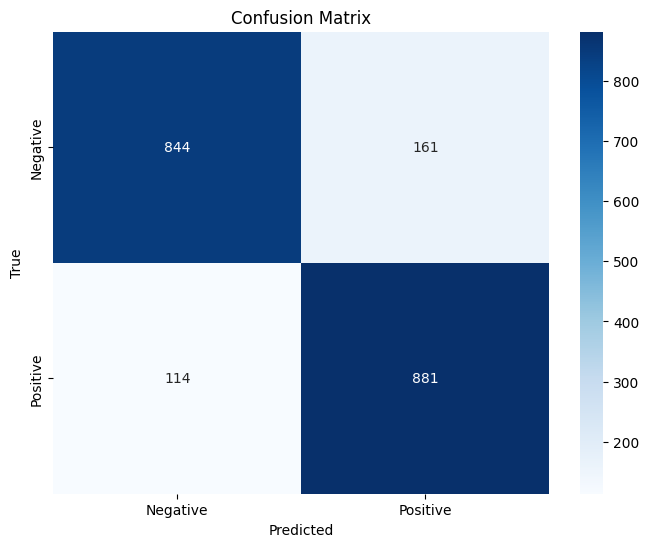


Misclassified Examples (showing 5 of 275 total errors):
Review: saw animation first time maybe really impressed completely different style compared japan animation kinda like tho whole impression movie sinister dark colors characters talk much long boring conversa...
True: Positive, Predicted: Negative
--------------------------------------------------
Review: overall would say liked movie fight scenes really good especially fight one point really bothered fact used asian play black man mean really talk bad taste fight scene see one fighters floor laughing ...
True: Positive, Predicted: Negative
--------------------------------------------------
Review: main character suffered loss wife child pre film past deals emotionally long movie much time spent face much road time one tv filling time moving cars trains etc long scenes trivial sometimes totally ...
True: Negative, Predicted: Positive
--------------------------------------------------
Review: black vengeance alternate title hung h

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

print("\nEvaluating model...")
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

def analyze_errors(X_test_data, y_test_data, y_pred_data, n=5):
    if hasattr(y_test_data, 'values'):
        y_test_array = y_test_data.values
    else:
        y_test_array = y_test_data

    if hasattr(y_pred_data, 'shape') and len(y_pred_data.shape) > 1:
        y_pred_array = y_pred_data.flatten()
    else:
        y_pred_array = y_pred_data

    errors = np.where(y_test_array != y_pred_array)[0]

    if len(errors) == 0:
        print("No errors found in the predictions!")
        return

    sample_errors = np.random.choice(errors, min(n, len(errors)), replace=False)

    print(f"\nMisclassified Examples (showing {len(sample_errors)} of {len(errors)} total errors):")
    for i in sample_errors:
        if hasattr(X_test_data, 'iloc'):
            text = str(X_test_data.iloc[i])[:200] + "..."
        else:
            text = str(X_test_data[i])[:200] + "..."

        if hasattr(y_test_data, 'iloc'):
            true_label = "Positive" if y_test_data.iloc[i] == 1 else "Negative"
        else:
            true_label = "Positive" if y_test_array[i] == 1 else "Negative"

        pred_label = "Positive" if y_pred_array[i] == 1 else "Negative"

        print(f"Review: {text}")
        print(f"True: {true_label}, Predicted: {pred_label}")
        print("-" * 50)


analyze_errors(X_test, y_test, y_pred)

#Create Prediction Function and Test

In [13]:
def predict_sentiment(review_text):
    cleaned = clean_text(review_text)

    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')

    prediction = model.predict(padded)[0][0]

    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return sentiment, confidence

example_reviews = [
    "This movie was fantastic! I really enjoyed every minute of it.",
    "What a terrible waste of time. The plot made no sense at all.",
    "The acting was mediocre but the storyline was intriguing.",
    "I've never been so bored watching a movie. Complete disappointment."
]

print("\nTesting with example reviews:")
for review in example_reviews:
    sentiment, confidence = predict_sentiment(review)
    print(f"Review: '{review}'")
    print(f"Sentiment: {sentiment} (confidence: {confidence:.2f})\n")


Testing with example reviews:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Review: 'This movie was fantastic! I really enjoyed every minute of it.'
Sentiment: Positive (confidence: 0.94)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Review: 'What a terrible waste of time. The plot made no sense at all.'
Sentiment: Negative (confidence: 1.00)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Review: 'The acting was mediocre but the storyline was intriguing.'
Sentiment: Negative (confidence: 0.98)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Review: 'I've never been so bored watching a movie. Complete disappointment.'
Sentiment: Negative (confidence: 0.97)



#Save Model

In [14]:
model.save('imdb_sentiment_lstm_model.h5')
print("Model saved as 'imdb_sentiment_lstm_model.h5'")


Model saved as 'imdb_sentiment_lstm_model.h5'
